In [1]:
"""
OptiGaussPy
==========
Herramienta interactiva para graficar pulsos gaussianos con chirp y dispersión cromática
en función de parámetros del Tx óptico, características y longitud de la fibra óptica.
"""
import numpy as np
from scipy import signal, constants
from scipy.signal import chirp, spectrogram
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button, RadioButtons
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import pint

ureg = pint.UnitRegistry()
pint._DEFAULT_REGISTRY = ureg
c_luz = constants.c * (ureg.meter) / (1 * ureg.second)
pi = constants.pi

In [2]:
def modulo(numero):
    """"
    Funcion auxiliar que calcula el modulo de un numero
    ===================================================
    recibe una variable de tipo pint.quantity
    retorna su módulo conservando sus unidades científicas
    """
    if numero.magnitude < 0:
        return -1 * numero
    else:
        return numero

In [3]:
def calculo_ensanchamiento_temporal_inicial(bitrate):
    """
    Calculo del ensalchamiento temporal inicial de un pulso gaussiano
    =================================================================
    Retorna una variable del tipo pint.quantity en 'second'
    Recibe el valor de bitrate del Tx Óptico
    en una variable del tipo pint.quantity en 'gigabit/second'
    tomando como ensanchamiento temporal inicial
    mitad de tiempo de bit
    """
    bps = bitrate.to_base_units() #bps
    tiempo_de_bit = 1 / (bps/ureg.bit) #s
    T_o = tiempo_de_bit / 2 #s
    return T_o

In [4]:
def calculo_beta2(lambda_o, dispersion_cromatica):
    """
    Calculo de β2
    ================
    Retorna una variable del tipo pint.quantity en 'picosecond ** 2 / kilometer'
    recibe dos variables del tipo pint.quantity
    lambda_o (λo) en 'nanometer'
    dispersion_cromatica (D(λ)) en 'picosecond / (nanometer * kilometer)'
    calcula β2 según la siguiente expresión:
    $\beta_2 = -\frac{\lambda^2}{2\pi c}D$
    """
    numerador = -( (lambda_o.to_base_units() **2) * dispersion_cromatica.to_base_units() )
    denominador = (2 * pi * c_luz)
    beta_2 = numerador / denominador
    return beta_2

In [5]:
def calculo_ensanchamiento_temporal(chirp_o, longitud, T_o, beta_2):
    """
    Calculo ensanchamiento temporal
    ===============================
    Retorna dos variables del tipo pint.quantity 
    T_z, ensanchamiento temporal en 'second'
    Tz_To, relación entre ensanchamientos temporales 'dimensionless'
    Recibe tres variables del tipo pint.quantity
    chirp_o, chirp inicial 'dimensionless'
    longitud de la fibra en 'kilometer'
    T_o, ensanchamiento temporal inicial en 'second'
    beta_2 en 'picosecond ** 2 / kilometer'
    #"$\frac{T_z}{T_o} = \sqrt{(1 + \frac{\beta_2zk_o}{To^2})^2+(\frac{\beta_2z}{T_o^2})^2}$"#
    """
    A = (beta_2.to_base_units() * longitud.to_base_units() * chirp_o) / (T_o.to_base_units()**2)
    B = (beta_2.to_base_units() * longitud.to_base_units()) / (T_o.to_base_units()**2)
    T_z = ( ( ((1 + A)**2) + B**2 ) ** (1/2) ) * T_o
    Tz_To = T_z / T_o
    return T_z, Tz_To

In [6]:
def calculo_chirp(T_o, chirp_o, longitud, beta_2):
    """
    Calculo chirp
    =============
    Retorna una variable del tipo pint.quantity 'dimensionless'
    con el valor del chirp del pulso gaussiano al cabo de longitud
    Recibe cuatro variables del tipo pint.quantity
    T_o, Ensanchamiento temporal inicial en 'second'
    chirp_o, Chirp inicial 'dimensionless'
    longitud, de la fibra en 'kilometer'
    beta_2 en 'picosecond ** 2 / kilometer'
    Calcula el chirp según la siguiente expresión:
    "$k_z = k_o + \frac{(1+k_o^2)\beta_2z}{T_0^2}$"
    #A = (beta_2.to_base_units() * longitud.to_base_units()) / (T_o**2).to_base_units()
    #chirp_z = chirp_o * (1 + chirp_o**2) + A
    """
    if longitud == (0 * ureg('kilometer')) :
        chirp_z = chirp_o
    else: 
        chirp_z = (beta_2.to_base_units() * longitud.to_base_units()) / (T_o**2).to_base_units() + chirp_o * (1 + chirp_o**2)
    
    return chirp_z

In [7]:
def calculo_longitud_dispersion(T_o, beta_2):
    """
    Calculo longitud de dispersion
    ==============================
    Retorna una variable del tipo pint.quantity
    L_Dispersion en 'kilometer'
    Recibe dos variables del tipo pint.quantity
    T_o, ensanchamiento temporal inicial en 'second'
    beta_2 en 'picosecond ** 2 / kilometer'
    Se calcula la longitud de dispersión segun la siguiente expresión:
    $L_D = \frac{2T_o}{\beta_2}$
    """
    if beta_2.magnitude == 0 :
        L_Dispersion = float('inf') * ureg('kilometer')
    else:
        mod_beta2 = (modulo(beta_2))
        L_Dispersion = ( (T_o**2) / (mod_beta2) ).to(ureg('kilometer'))
        
    return L_Dispersion

In [8]:
def calculo_parametros(bitrate, lambda_o , dispersion_cromatica, chirp_o, longitud):
    """
    Calculo de parametros
    =====================
    Retorna 6 variables del tipo pint.quantity
    T_o, ensanchamiento temporal inicial en 'second'
    T_z, ensanchamiento temporal en 'second'
    Tz_To, relación entre ensanchamientos temporales 'dimensionless'
    beta_2 en 'picosecond ** 2 / kilometer'
    chirp_z, chirp del pulso gaussiano al cabo de longitud 'dimensionless'
    L_Dispersion en 'kilometer'
    Recibe 5 variables del tipo pint.quantity
    bitrate, del tipo pint.quantity en 'gigabit/second'
    (λo) en 'nanometer'
    dispersion_cromatica (D(λ)) en 'picosecond / (nanometer * kilometer)'
    chirp_o, chirp inicial 'dimensionless'
    longitud de la fibra en 'kilometer'
    ==================
    Funciones internas
    =======================================
    calculo_ensanchamiento_temporal_inicial
    calculo_ensanchamiento_temporal
    calculo_beta2
    calculo_chirp
    calculo_longitud_dispersion
    =======================================
    """
    T_o = calculo_ensanchamiento_temporal_inicial(bitrate)
    beta_2 = calculo_beta2(lambda_o, dispersion_cromatica)
    T_z, Tz_To = calculo_ensanchamiento_temporal(chirp_o, longitud, T_o, beta_2)
    chirp_z = calculo_chirp(T_o, chirp_o, longitud, beta_2)
    L_Dispersion = calculo_longitud_dispersion(T_o, beta_2)
    return T_o, beta_2, T_z, Tz_To, chirp_z, L_Dispersion

In [9]:
def calculo_frecuencias_ploteo(chirp):
    """
    Calculo frecuencias de ploteo
    =============================
    Retorna dos variables del tipo int
    f0, frecuencia inicial de la señal con chirp
    f1, frecuencia a T_z de la señal con chirp
    Recibe una variable del tipo pint.quantity
    chirp 'dimensionless'
    ====
    NOTA
    =============================================================
    Dado que el valor real de chirp (kz) no resulta apreciable
    la gráfica, se genera una función con chirp cuyas frecuencias
    inicial y final se relacionan mediante un coeficiente
    proporcional al chirp calculado.
    """
    chirp = int(chirp)
    if chirp == 0 :
        f0_plot = 1
        f1_plot = f0_plot
    elif chirp > 0:
        f0_plot = 1 
        f1_plot = 2 * chirp
    else:
        f0_plot = -2 * chirp 
        f1_plot = 1 
    return f0_plot, f1_plot

In [10]:
def plot_chirp(T_o, T_z, chirp_z):
    To_plot = int(T_o.to(ureg('picosecond')).magnitude)
    Tz_plot = int(T_z.to(ureg('picosecond')).magnitude)
    t_plot_chirp = np.linspace(0, Tz_plot/5, To_plot*500)
    f0_plot, f1_plot = calculo_frecuencias_ploteo(chirp_z)
    cos_chirp = chirp(t_plot_chirp, f0=f0_plot, f1=f1_plot, t1=Tz_plot/5)
    return cos_chirp

In [11]:
def plot_e_gauss(T_o, T_z):
    To_plot = int(T_o.to(ureg('picosecond')).magnitude)
    Tz_plot = int(T_z.to(ureg('picosecond')).magnitude)
    t_plot_gauss = np.linspace(-3*Tz_plot, 3*Tz_plot, To_plot*500)
    A = round(T_o/T_z, 4)
    i, q, env = A * signal.gausspulse(t_plot_gauss, fc=1/Tz_plot, retquad=True, retenv=True)
    return t_plot_gauss, env

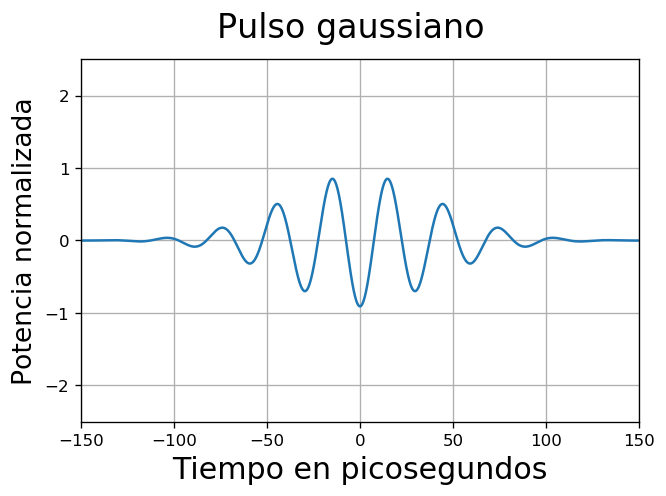

Beta2 =  -22.958067590909895 picosecond ** 2 / kilometer
To =  50.0 picosecond
Long Dispersion =  108.8941824088827 kilometer
Tz = 55.01884102295128 picosecond
Tz/To = 1.1003768204590256 dimensionless
Chirp = -0.4591613518181979 dimensionless


In [12]:
def plot(wbitrate, wchirp_o, wlambda_o, wdispersion_cromatica, wlongitud):
    """
    Plot
    ====
    Genera un gráfico dinámico de un pulso gaussiano
    con dispersión cromática y chirp
    actualizando sus propiedades en tiempo real
    según el usuario modifica los parámetros iniciales
    Recibe 5 variables del tipo ipywidgets.widgets
    que permiten al usuario setear los valores iniciales
    del bitrate, chirp (ko), lambda inicial λo,
    Dispersión cromática D(λ) y longitud de la F.O.
    ====================================================
    Obtiene los valores numéricos de cada widget
    acompañados por sus correspondientes unidades científicas
    para el cálculo de parámetros necesarios para el gráfico
    con la función calculo_parametros
                   ==================
    """
    bitrate = wbitrate * ureg('gigabit/second')
    chirp_o = wchirp_o * ureg('dimensionless')
    lambda_o = wlambda_o * ureg('nanometer')
    dispersion_cromatica = wdispersion_cromatica * ureg('picosecond / (nanometer * kilometer)')
    longitud = wlongitud * ureg('kilometer')
    
    T_o, beta_2, T_z, Tz_To, chirp_z, L_Dispersion = calculo_parametros(bitrate, lambda_o , dispersion_cromatica, chirp_o, longitud)    
    
    t_plot_gauss, env = plot_e_gauss(T_o, T_z)
    cos_chirp = plot_chirp(T_o, T_z, chirp_z)
    pulso_gaussiano = cos_chirp * env
    To_plot = int(T_o.to(ureg('picosecond')).magnitude)
    Tz_plot = int(T_z.to(ureg('picosecond')).magnitude)
    plt.figure(1, dpi=120)
    plt.plot(t_plot_gauss, pulso_gaussiano)
    plt.grid(True)
    plt.figure(1).suptitle('Pulso gaussiano', fontsize=20)
    plt.xlabel('Tiempo en picosegundos', fontsize=18)
    plt.ylabel('Potencia normalizada', fontsize=16)
    plt.xlim([-3*To_plot, 3*To_plot])
    plt.ylim([-2.5, 2.5])
    plt.show()
    print('Beta2 = ', beta_2.to(ureg('picosecond ** 2 / kilometer')))
    print('To = ', T_o.to(ureg('picosecond')))
    print('Long Dispersion = ', L_Dispersion)
    print('Tz =', T_z.to(ureg('picosecond')))
    print('Tz/To =', Tz_To)
    print('Chirp =', chirp_z)
    
wbitrate = widgets.FloatSlider(min=1,max=10,step=1,value=10, description='Bitrate Gbps')
wchirp_o = widgets.IntSlider(min=-5,max=5,step=1,value=0, description='Chirp inicial')
wlambda_o = widgets.IntSlider(min=850,max=1550,step=10,value=15500, description='λo nm')
wdispersion_cromatica =  widgets.IntSlider(min=0,max=20,step=1,value=18, description='D ps/(nm·km)')
wlongitud = widgets.IntSlider(min=0,max=500,step=1,value=50, description='Longitud km')

interactive_plot = interactive(plot, wbitrate = wbitrate, wchirp_o = wchirp_o, wlambda_o = wlambda_o, wdispersion_cromatica = wdispersion_cromatica, wlongitud = wlongitud)
output = interactive_plot.children[-1]
output.layout.height = '800px'
interactive_plot